# Computing ground-truth generalized likelihood
via the integral:

$$ L(\theta|x_o) = \int{p(x|\theta)e^{-\beta d(x,x_o)}}dx$$

where

- $p(x|\theta)$ is given analytically by the simulator,
- $d(x,x_o)$ is the chosen distance function in data space,
- $\beta$ is a scaling factor over distance (temperature).

---

to dos:
- make generalized_likelihood handle batch thetas
- write likelihood_fn for the other tasks

In [1]:
import sbibm
import torch
import matplotlib.pyplot as plt

In [2]:
def mse_dist(xs, x_o):
    return torch.mean((xs - x_o)**2, dim=1)

def make_2d_grid(d1_bounds, d2_bounds, d1_res=100, d2_res=100):
    x1 = torch.linspace(*d1_bounds, d1_res)
    x2 = torch.linspace(*d2_bounds, d2_res)
    xs = torch.stack(torch.meshgrid(x1, x2))
    xs = torch.reshape(xs, (2, d1_res*d2_res)).T
    return xs

def generalized_likelihood(thetas, x_o, xs, dist_func, log_prob_fn, beta=1.):    
    # pad batch dimension
    if thetas.dim()==1:
        thetas = thetas.unsqueeze(0)
    
    # only have to compute this once for the x grid
    tempered_distances = (-beta * dist_func(xs, x_o)).exp()
    
    # loop over all thetas to get generalized likelihood
    integral = torch.stack([(tempered_distances * log_prob_fn(theta, xs).exp()).sum() for theta in thetas])
    return integral

In [16]:
print(sbibm.get_available_tasks())

task_name =  "two_moons" # "gaussian mixture" has no likelihood
obs_num = 3

task = sbibm.get_task(task_name)
log_prob_fn = task._likelihood
prior = task.get_prior()
x_o = task.get_observation(num_observation=obs_num)
beta = 1000.

xs = make_2d_grid((-1,1), (-1.5, 1.5), 100,100)
th_res = (250, 250)
thetas = make_2d_grid((-1,1), (-1,1), th_res[0], th_res[1])

# theta = torch.Tensor([1,1])
# generalized_likelihood(theta, x_o, xs, mse_dist, log_prob_fn, beta=1000.)

['two_moons', 'gaussian_mixture', 'gaussian_linear', 'bernoulli_glm', 'gaussian_linear_uniform', 'slcp', 'sir', 'lotka_volterra', 'slcp_distractors', 'bernoulli_glm_raw']


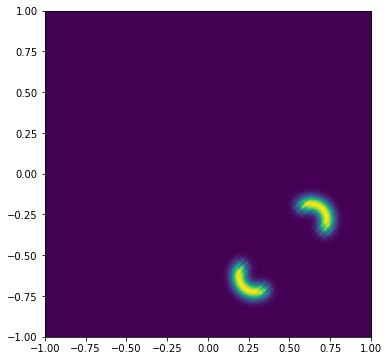

In [17]:
gl = generalized_likelihood(thetas, x_o, xs, mse_dist, log_prob_fn, beta)
gl = torch.reshape(gl, th_res)
plt.figure(figsize=(6,6))
_ = plt.imshow(gl.numpy().T, extent=[-1,1,-1,1], origin='lower')

In [18]:
from sbi.inference import MCMCPosterior, RejectionPosterior
from sbi.inference.potentials.base_potential import BasePotential
from sbi.utils import BoxUniform

In [19]:
class MyPotential(BasePotential):
    allow_iid_x = False
    def __init__(self, prior, x_o):
        super().__init__(prior, x_o)
        
    def __call__(self, theta, track_gradients = True):
        return generalized_likelihood(theta, x_o, xs, mse_dist, log_prob_fn, beta).log() + prior.log_prob(theta)

In [22]:
prior = BoxUniform(low=torch.Tensor((-1, -1)), high=torch.Tensor((1, 1)))
gbi_potential = MyPotential(prior, x_o)
# sampler = MCMCPosterior(gbi_potential, prior)
sampler = RejectionPosterior(gbi_potential, prior)
theta_posterior_samples = sampler.sample((100,))
theta_np = theta_posterior_samples.numpy()

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

(-1.0, 1.0)

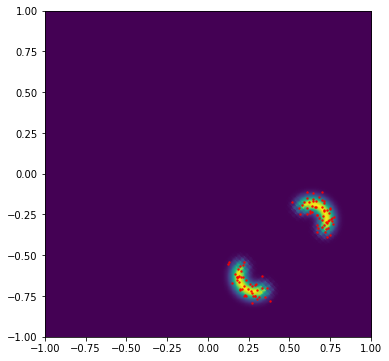

In [23]:
plt.figure(figsize=(6,6))
plt.imshow(gl.numpy().T, extent=[-1,1,-1,1], origin='lower')
plt.plot(theta_np[:,0], theta_np[:,1], 'r.', ms=3, alpha=0.8)
plt.xlim([-1,1]); plt.ylim([-1,1])